In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns

# Preprocessing

In [6]:
url = "https://raw.githubusercontent.com/manojaryalgit/nepal-earthquake-mb-data/refs/heads/main/mbEQDatabyManoj.csv"
df = pd.read_csv(url)

# Preprocess the df
# Strip any extra whitespace in column names and values
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert numeric columns explicitly, replacing invalid strings with NaN
numeric_cols = ['LAT', 'LON', 'DEPTH', 'MAG']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Drop rows with missing or invalid values
df = df.dropna()
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%Y/%m/%d %H:%M:%S')
df = df.sort_values('Date and Time')
df.set_index('Date and Time',inplace=True)

/tmp/ipykernel_146559/585223165.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [7]:
df.head()

,LAT,LON,DEPTH,MAG
Date and Time,,,,
1966-01-11 12:42:07,27.8486,85.9525,19.0,4.5
1966-06-25 12:05:05,30.2342,82.0498,35.0,4.8
1966-06-27 10:41:09,29.4815,80.8388,27.9,6.0
1966-06-27 10:47:47,29.9370,80.8036,35.0,5.3
1966-06-27 10:49:47,29.4295,80.8609,17.0,5.6


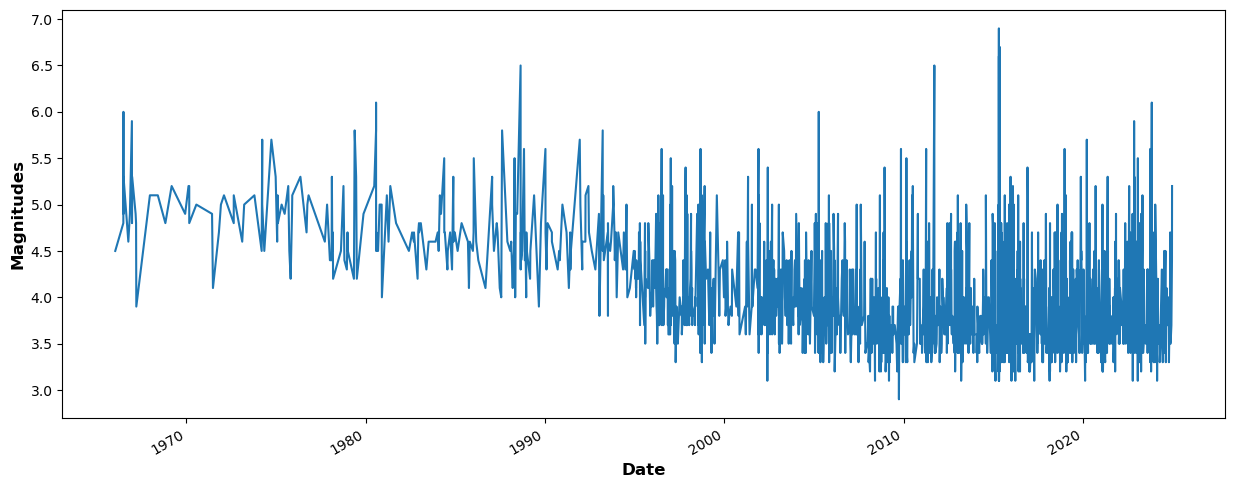

In [8]:
df["MAG"].plot(figsize=(15,6))
plt.xlabel("Date",fontweight='bold',fontsize=12)
plt.ylabel("Magnitudes", fontweight='bold',fontsize=12)
plt.savefig("magnitude time series12.png",dpi=300)

<Axes: xlabel='Date and Time'>

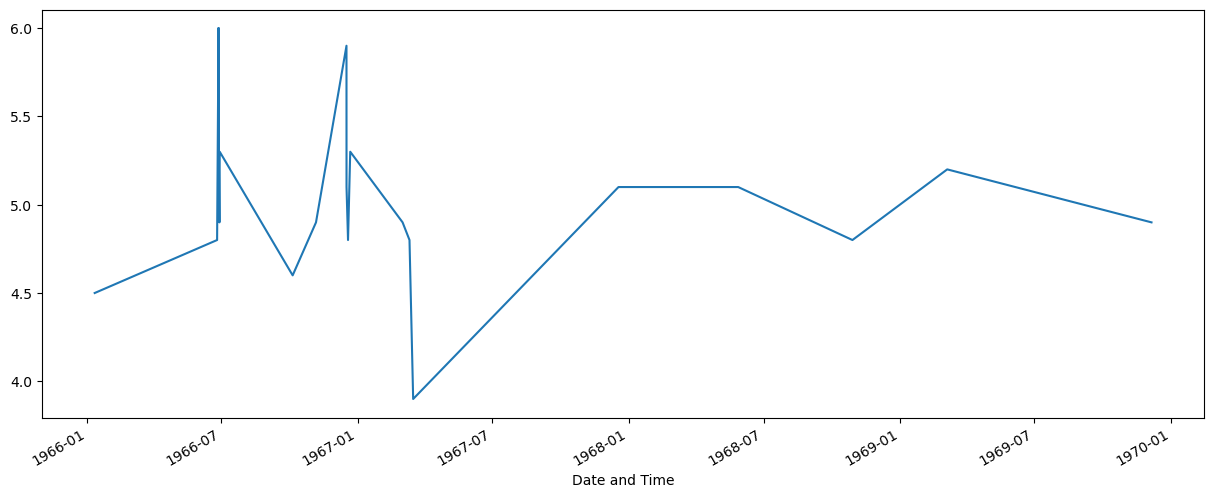

In [9]:
df["MAG"].loc[:"1970-01-01"].plot(figsize=(15,6))

<Axes: xlabel='Date and Time'>

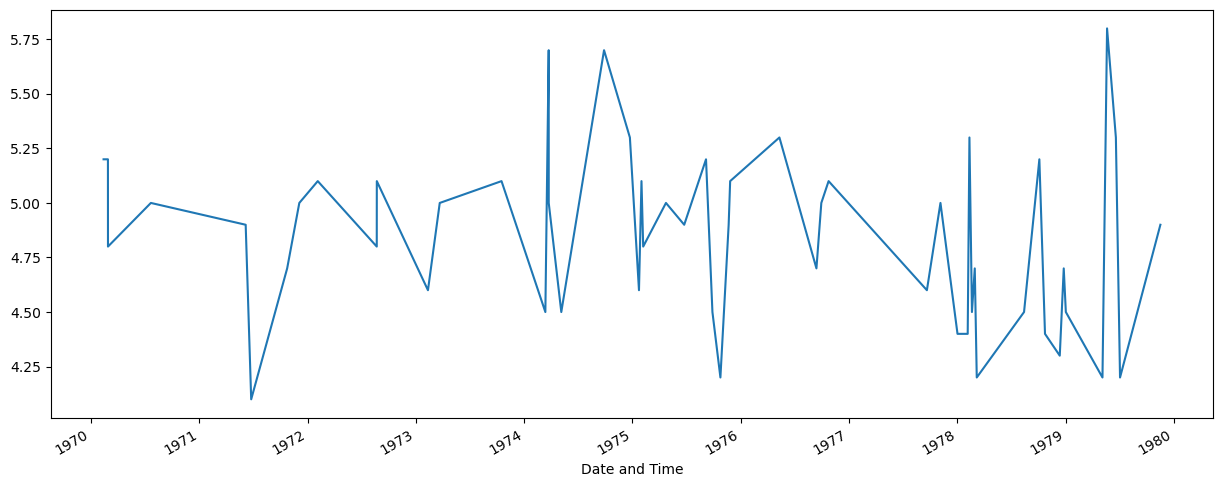

In [10]:
df["MAG"].loc["1970-01-01":"1980-01-01"].plot(figsize=(15,6))

<Axes: xlabel='Date and Time'>

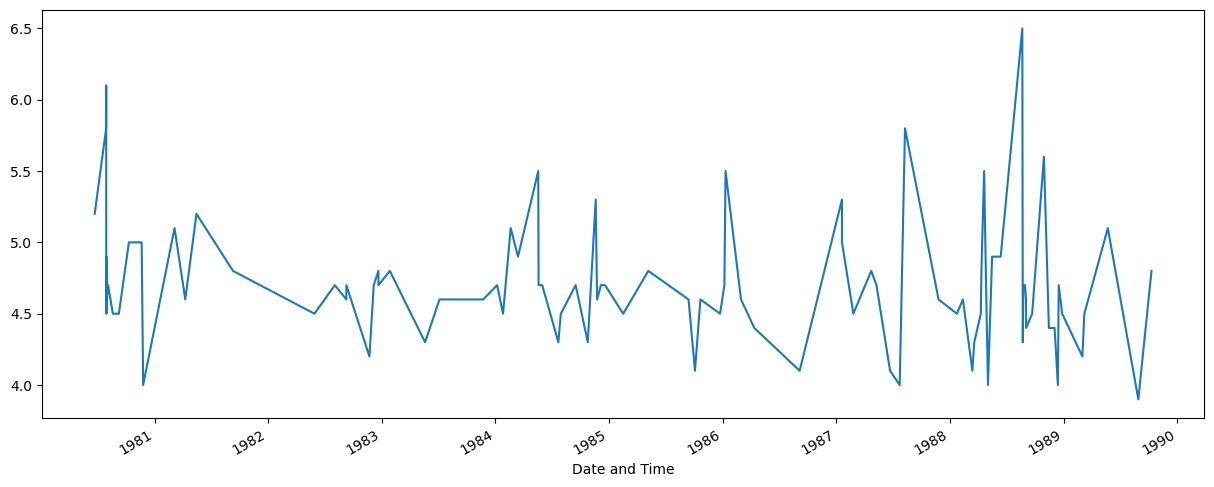

In [11]:
df["MAG"].loc["1980-01-01":"1990-01-01"].plot(figsize=(15,6))

<Axes: xlabel='Date and Time'>

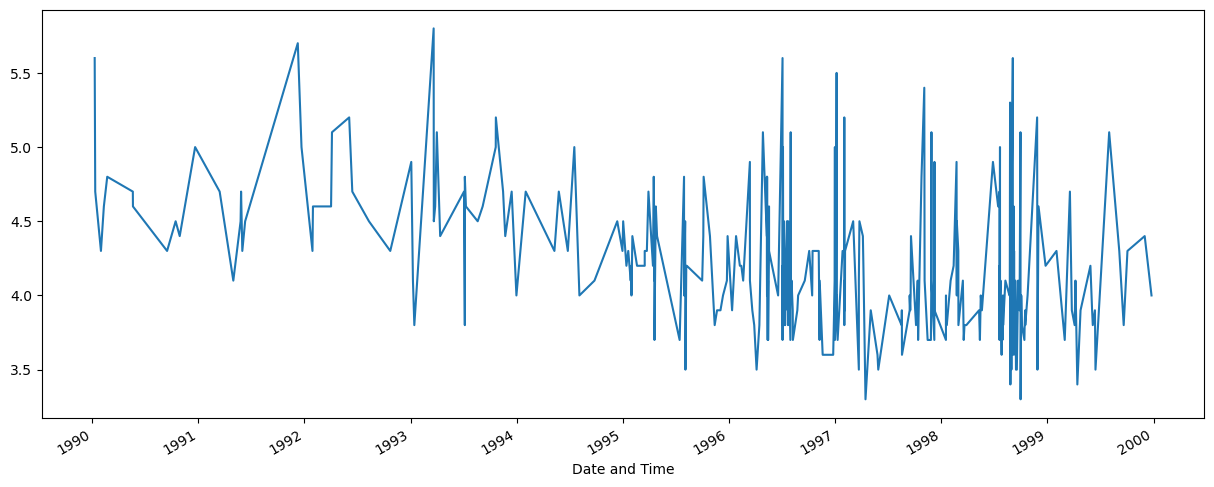

In [12]:
df["MAG"].loc["1990-01-01":"2000-01-01"].plot(figsize=(15,6))

(2426,)


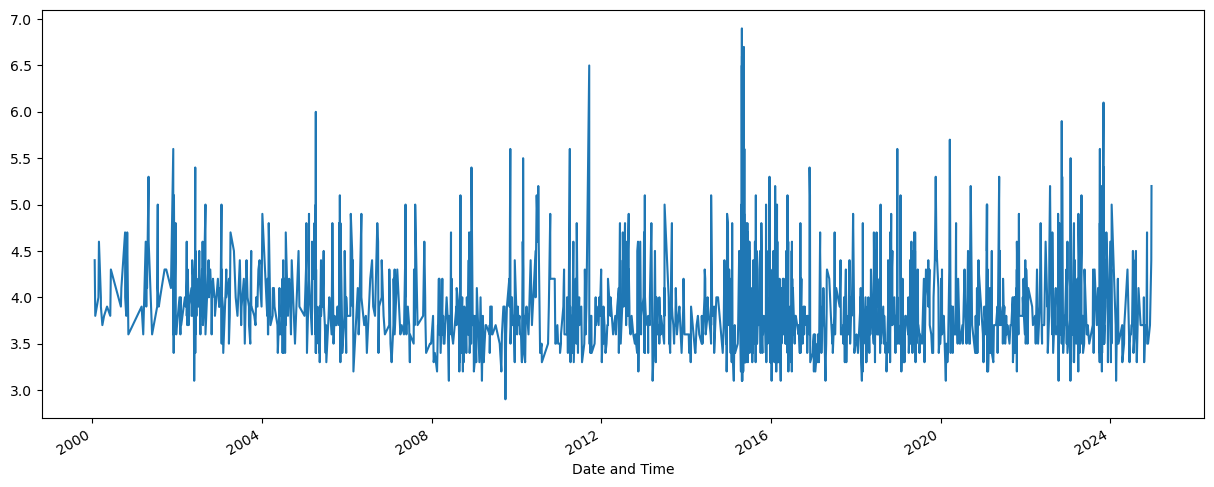

In [13]:
df["MAG"].loc["2000-01-01":].plot(figsize=(15,6))
print(df["MAG"].loc["2000-01-01":].shape)

/tmp/ipykernel_146559/1858630660.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["MAG"])


Text(0, 0.5, 'Density')

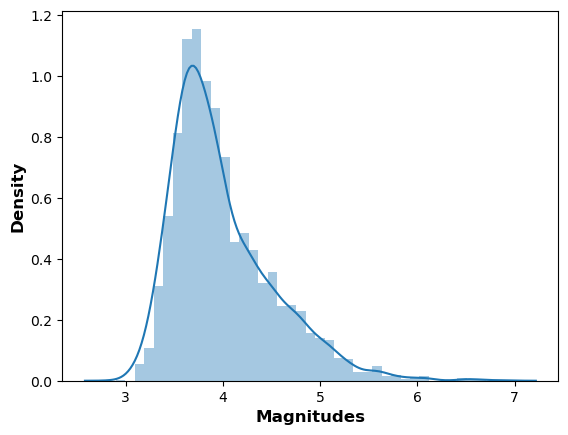

In [14]:
sns.distplot(df["MAG"])
plt.xlabel("Magnitudes",fontweight='bold',fontsize=12)
plt.ylabel("Density", fontweight='bold',fontsize=12)
#plt.savefig("magnitude dist123.png",dpi=300)

In [15]:
df.describe()

,LAT,LON,DEPTH,MAG
count,2936.000000,2936.000000,2936.000000,2936.000000
mean,28.699167,85.002698,19.525783,3.985354
std,1.014379,2.366878,17.243062,0.524763
min,26.306700,80.003500,0.000000,2.900000
25%,27.794475,83.292850,10.000000,3.600000
50%,28.444300,85.591050,17.000000,3.900000
75%,29.656375,86.812150,33.000000,4.300000
max,30.499600,88.298200,106.600000,6.900000


# Feature Extracting and Creating

# max , mean and min of last 30 days

In [18]:
df['MAG_Rolling_Mean30_1'] = df['MAG'].rolling(window=30).mean().shift(1)
df['MAG_Rolling_max30_1'] = df['MAG'].rolling(window=30).max().shift(1)
df['MAG_Rolling_min30_1'] = df['MAG'].rolling(window=30).min().shift(1)

# max , mean and min of last 7 days

In [20]:
df['MAG_Rolling_Mean7_1'] = df['MAG'].rolling(window=7).mean().shift(1)
df['MAG_Rolling_max7_1'] = df['MAG'].rolling(window=7).max().shift(1)
df['MAG_Rolling_min7_1'] = df['MAG'].rolling(window=7).min().shift(1)

# TIME SINCE LAST EARTHQUAKE

In [22]:
df['Days_Since_Last'] = df.index.diff().total_seconds() / (24 * 60 * 60)

# CALCULATION OF THE GUTENBERG-RICHTER b-VALUE and a value of last 50 days

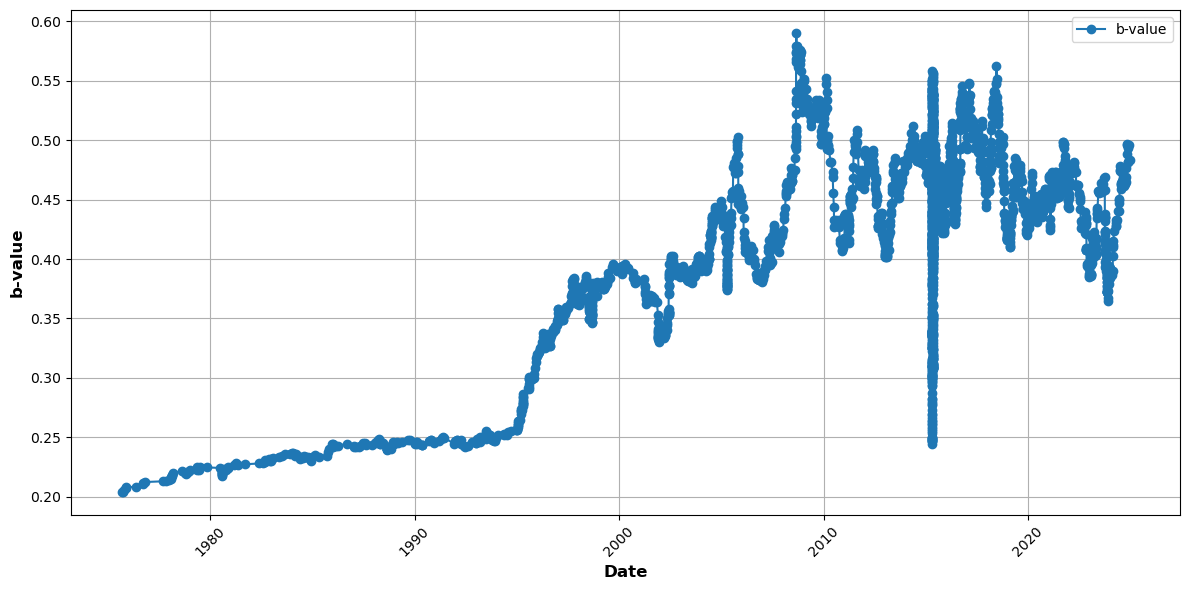

              Start_Date            End_Date         a         b
0    1966-01-11 12:42:07 1975-09-06 04:44:35  2.725670  0.204278
1    1966-06-25 12:05:05 1975-09-27 19:46:41  2.725670  0.204278
2    1966-06-27 10:41:09 1975-10-24 17:44:19  2.729033  0.205437
3    1966-06-27 10:47:47 1975-11-21 13:49:30  2.735298  0.207598
4    1966-06-27 10:49:47 1975-11-26 15:02:36  2.736451  0.207995
...                  ...                 ...       ...       ...
2881 2023-12-13 01:56:58 2024-11-12 08:30:36  3.529555  0.481479
2882 2023-12-31 16:36:23 2024-11-13 15:58:31  3.529555  0.481479
2883 2024-01-04 04:32:44 2024-11-21 04:28:03  3.564462  0.493516
2884 2024-01-06 13:42:18 2024-12-07 17:08:30  3.570997  0.495770
2885 2024-01-07 14:08:36 2024-12-19 01:52:47  3.535775  0.483624

[2886 rows x 4 columns]


In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Define sliding window size (30 days)
window_size = 50

# Initialize results list
results = []

# Loop over the sliding windows
start_idx = 0
while start_idx < len(df) - window_size:
    # Select the data within the current window
    window_df = df.iloc[start_idx : start_idx + window_size]
    start_date = window_df.index[0]
    end_date = window_df.index[-1]
    x=np.log10(np.exp(1))
    n=len(window_df[window_df["MAG"]>=2.9]["MAG"])
    m_avg=window_df[window_df["MAG"]>=2.9]["MAG"].mean()
    m_min=df["MAG"].min()
    b=x/(m_avg-m_min)
    a=np.log10(n)+b*m_avg
    # Append results for the current window
    results.append({'Start_Date': start_date, 'End_Date': end_date, 'a': a, 'b': b})

    # Slide the window forward by one day
    start_idx += 1

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Drop rows where fitting wasn't possible
results_df = results_df.dropna()

# Plot b-value trends over time
plt.figure(figsize=(12, 6))
plt.plot(results_df['End_Date'], results_df['b'], label='b-value', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Date',fontweight='bold',fontsize=12)
plt.ylabel('b-value',fontweight='bold',fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("b-value over time.png",dpi=300)

plt.show()

# Display results
print(results_df)

In [25]:
results_df.set_index("End_Date",inplace=True)

In [26]:
df["b_value"]=results_df["b"]
df["a_value"]=results_df["a"]
df["a_value_1"]=df["a_value"].shift(1)
df["b_value_1"]=df["b_value"].shift(1)

In [27]:
df.drop(columns=["b_value","a_value"],inplace=True)

# CALCULATION OF INCREMENTAL b-VALUES

In [29]:
df["incremental_b_value_0-2"]=df["b_value_1"]-df["b_value_1"].shift(2)
df["incremental_b_value_2_shift_2-4"]=df["b_value_1"].shift(2)-df["b_value_1"].shift(4)
df["incremental_b_value_2_shift_4-6"]=df["b_value_1"].shift(4)-df["b_value_1"].shift(6)
df["incremental_b_value_2_shift_6-8"]=df["b_value_1"].shift(6)-df["b_value_1"].shift(8)
df["incremental_b_value_2_shift_8-10"]=df["b_value_1"].shift(8)-df["b_value_1"].shift(10)

# ratio feature

In [31]:
df["b/a_1"]=df["b_value_1"]/df["a_value_1"]
df["a/b_1"]=df["a_value_1"]/df["b_value_1"]

# magnitude lag

In [33]:
df["MAG_1"]=df["MAG"].shift(1)
df["MAG_2"]=df["MAG"].shift(2)
df["MAG_3"]=df["MAG"].shift(3)
df["MAG_4"]=df["MAG"].shift(4)

# SUM OF THE MEAN SQUARE DEVIATION (η) FROM THE REGRESSION LINE BASED ON THE GUTENBERG-RICHTER LAW

In [35]:
df["del_M"]=df["MAG_1"]-df["a/b_1"]

# clustering location

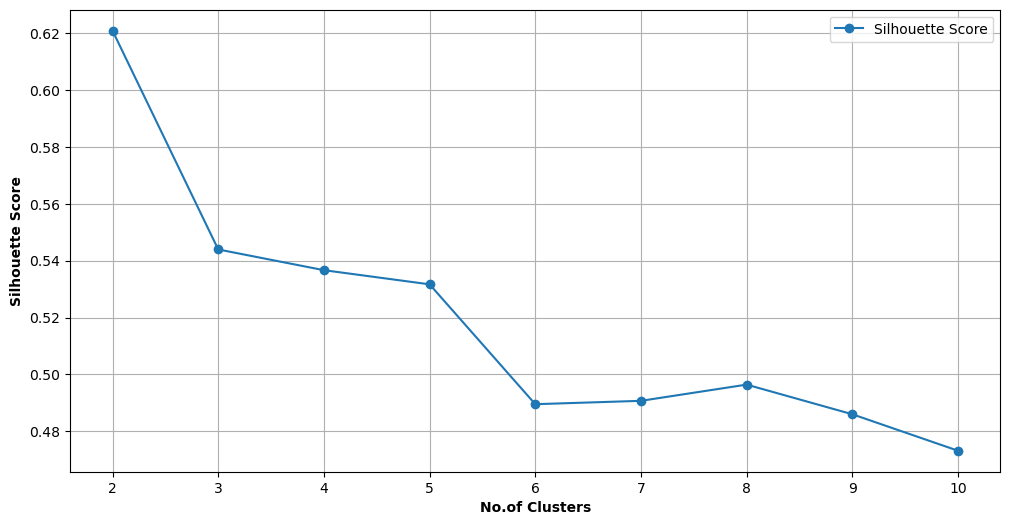

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# Initialize variables
range_n_clusters = range(2, 11)  # Try from 2 to 10 clusters
silhouette_scores = []
inertias = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df[['LAT', 'LON']])

    # Compute inertia (Sum of Squared Distances)
    inertias.append(kmeans.inertia_)

    # Compute silhouette score
    if n_clusters > 1:  # Silhouette score is valid for n_clusters > 1
        score = silhouette_score(df[['LAT', 'LON']], cluster_labels)
        silhouette_scores.append(score)

# Plotting Silhouette Scores

plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', label="Silhouette Score")
plt.xlabel("No.of Clusters",fontweight='bold')
plt.ylabel("Silhouette Score",fontweight='bold')
plt.grid()
plt.legend()
plt.savefig("Silhouette Score for Different Number of Clusters2.png",dpi=300)
plt.show()
#df['Location_Cluster'] = kmeans.fit_predict(df[['LAT', 'LON']])

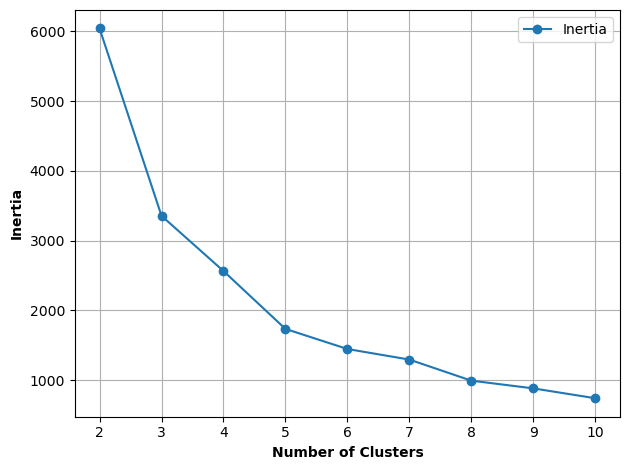

In [38]:
# Plotting Inertia
plt.plot(range_n_clusters, inertias, marker='o', label="Inertia")
plt.xlabel("Number of Clusters",fontweight='bold')
plt.ylabel("Inertia",fontweight='bold')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig("Inertia (Elbow Method).png",dpi=300)

plt.show()


In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Location_Cluster'] = kmeans.fit_predict(df[['LAT', 'LON']])

# distance from centroids

In [41]:
centroids = kmeans.cluster_centers_
centroids

array([[29.55364362, 81.74054577],
       [29.02066413, 87.60090859],
       [27.94563748, 85.50546577]])

In [42]:
from geopy.distance import geodesic
df['Distance_to_cluster centroids_1'] = df.apply(lambda row: geodesic((row['LAT'], row['LON']), centroids[0]).km, axis=1)
df['Distance_to_cluster centroids_2'] = df.apply(lambda row: geodesic((row['LAT'], row['LON']), centroids[1]).km, axis=1)
df['Distance_to_cluster centroids_3'] = df.apply(lambda row: geodesic((row['LAT'], row['LON']), centroids[2]).km, axis=1)

# previous lat and lon

In [44]:
df["LAT_1"]=df["LAT"].shift(1)
df["LON_1"]=df["LON"].shift(1)

# PROBABILITY OF EVENTS WITH MAGNITUDE ≥ 5

In [46]:
min_mag=df["MAG"].min()

In [47]:
df["p-value_greater_5"]=10**(-df["b_value_1"]*(5-min_mag))

# THE SQUARE ROOT OF THE CUMULATIVE SEISMIC ENERGY

In [49]:
df['sqrt_Energy_Release'] = np.sqrt((10 ** (1.5 * df['MAG'] + 4.8)).rolling(window=50).sum()).shift(1)

# Earthquake count since 30 days

In [51]:
df['Earthquake_count'] = df["MAG"].rolling('30D').count().shift(1)



# Expanding mean

In [53]:
df['MAG_Cumulative_Mean_1'] = df['MAG'].expanding().mean().shift(1)

# Interaction Features

In [55]:
df['Dist_Mag_Interaction_c1'] = (df['Distance_to_cluster centroids_1'] * df['MAG']).shift(1)
df['Dist_Mag_Interaction_c2'] = (df['Distance_to_cluster centroids_2'] * df['MAG']).shift(1)
df['Dist_Mag_Interaction_c3'] = (df['Distance_to_cluster centroids_3'] * df['MAG']).shift(1)

df['Lat_Depth_Interaction'] = df['LAT'] * df['DEPTH']
df['Lon_Depth_Interaction'] = df['LON'] * df['DEPTH']
df['Lat_Lon_Interaction'] = df['LAT'] * df['LON']

# timed base feature

In [57]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['second'] = df.index.second
df['weekday'] = df.index.weekday

# Cyclic features for 'hour', 'month', and 'weekday'
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

In [58]:
df["Depth_1"]=df["DEPTH"].shift(1)

In [59]:

def calculate_days_since_last_eq(df, magnitude_threshold=6):
    days_since_last_eq = []
    last_eq_date = None
    
    for index, row in df.iterrows():
        if row['MAG'] >= magnitude_threshold:
            last_eq_date = index
        
        if last_eq_date is None:
            days_since_last_eq.append(-1)  # No earthquake above threshold yet
        else:
            days_since_last_eq.append((index - last_eq_date).days)
    
    df['days_since_last_eq_gt{}'.format(magnitude_threshold)] = days_since_last_eq
    return df
df=calculate_days_since_last_eq(df,6)
df=calculate_days_since_last_eq(df,5)
df=calculate_days_since_last_eq(df,4)

In [60]:
df.head(20)

,LAT,LON,DEPTH,MAG,MAG_Rolling_Mean30_1,MAG_Rolling_max30_1,MAG_Rolling_min30_1,MAG_Rolling_Mean7_1,MAG_Rolling_max7_1,MAG_Rolling_min7_1,...,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,Depth_1,days_since_last_eq_gt6,days_since_last_eq_gt5,days_since_last_eq_gt4
Date and Time,,,,,,,,,,,,,,,,,,,,,
1966-01-11 12:42:07,27.8486,85.9525,19.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,...,1.224647e-16,-1.000000e+00,5.000000e-01,8.660254e-01,0.781831,0.623490,NaN,-1,-1,0
1966-06-25 12:05:05,30.2342,82.0498,35.0,4.8,NaN,NaN,NaN,NaN,NaN,NaN,...,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,19.0,-1,-1,0
1966-06-27 10:41:09,29.4815,80.8388,27.9,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,35.0,0,0,0
1966-06-27 10:47:47,29.9370,80.8036,35.0,5.3,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,27.9,0,0,0
1966-06-27 10:49:47,29.4295,80.8609,17.0,5.6,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,35.0,0,0,0
1966-06-27 10:59:19,29.7075,80.9233,23.8,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,17.0,0,0,0
1966-06-27 11:21:44,29.5704,80.8414,28.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,...,2.588190e-01,-9.659258e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,23.8,0,0,0
1966-06-27 13:55:52,29.6944,80.8136,23.2,5.4,NaN,NaN,NaN,5.357143,6.0,4.5,...,-2.588190e-01,-9.659258e-01,1.224647e-16,-1.000000e+00,0.000000,1.000000,28.6,0,0,0
1966-06-28 15:43:39,29.4786,80.8448,17.0,4.9,NaN,NaN,NaN,5.485714,6.0,4.8,...,-7.071068e-01,-7.071068e-01,1.224647e-16,-1.000000e+00,0.781831,0.623490,23.2,1,1,0


In [61]:
df.describe()

,LAT,LON,DEPTH,MAG,MAG_Rolling_Mean30_1,MAG_Rolling_max30_1,MAG_Rolling_min30_1,MAG_Rolling_Mean7_1,MAG_Rolling_max7_1,MAG_Rolling_min7_1,...,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,Depth_1,days_since_last_eq_gt6,days_since_last_eq_gt5,days_since_last_eq_gt4
count,2936.000000,2936.000000,2936.000000,2936.000000,2906.000000,2906.000000,2906.000000,2929.000000,2929.000000,2929.000000,...,2936.000000,2.936000e+03,2936.000000,2936.000000,2936.000000,2936.000000,2935.000000,2936.000000,2936.000000,2936.000000
mean,28.699167,85.002698,19.525783,3.985354,3.979836,5.222505,3.355678,3.983807,4.650905,3.530010,...,-0.031326,-5.345958e-02,0.162305,-0.187990,-0.062675,0.047503,19.521533,1420.910082,105.559605,7.592984
std,1.014379,2.366878,17.243062,0.524763,0.275348,0.544668,0.240861,0.329781,0.565172,0.293027,...,0.715627,6.959728e-01,0.691185,0.678896,0.727868,0.681442,17.244462,1631.656475,155.264605,19.228888
min,26.306700,80.003500,0.000000,2.900000,3.566667,4.000000,2.900000,3.342857,3.600000,2.900000,...,-1.000000,-1.000000e+00,-1.000000,-1.000000,-0.974928,-0.900969,0.000000,-1.000000,-1.000000,0.000000
25%,27.794475,83.292850,10.000000,3.600000,3.796667,4.800000,3.200000,3.771429,4.200000,3.400000,...,-0.707107,-7.071068e-01,-0.500000,-0.866025,-0.781831,-0.222521,10.000000,11.000000,0.000000,0.000000
50%,28.444300,85.591050,17.000000,3.900000,3.900000,5.100000,3.300000,3.914286,4.600000,3.500000,...,0.000000,-1.836970e-16,0.500000,-0.500000,0.000000,-0.222521,17.000000,849.000000,34.000000,0.000000
75%,29.656375,86.812150,33.000000,4.300000,4.049167,5.600000,3.400000,4.100000,5.000000,3.600000,...,0.707107,7.071068e-01,0.866025,0.500000,0.781831,0.623490,33.000000,2369.000000,146.000000,6.000000
max,30.499600,88.298200,106.600000,6.900000,5.066667,6.900000,4.200000,5.700000,6.900000,4.900000,...,1.000000,1.000000e+00,1.000000,1.000000,0.974928,1.000000,106.600000,6073.000000,985.000000,226.000000


In [62]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df.isnull().sum()

LAT                                  0
LON                                  0
DEPTH                                0
MAG                                  0
MAG_Rolling_Mean30_1                30
MAG_Rolling_max30_1                 30
MAG_Rolling_min30_1                 30
MAG_Rolling_Mean7_1                  7
MAG_Rolling_max7_1                   7
MAG_Rolling_min7_1                   7
Days_Since_Last                      1
a_value_1                           50
b_value_1                           50
incremental_b_value_0-2             52
incremental_b_value_2_shift_2-4     54
incremental_b_value_2_shift_4-6     56
incremental_b_value_2_shift_6-8     58
incremental_b_value_2_shift_8-10    60
b/a_1                               50
a/b_1                               50
MAG_1                                1
MAG_2                                2
MAG_3                                3
MAG_4                                4
del_M                               50
Location_Cluster         

In [63]:
df.dropna(inplace=True)

In [64]:
df.shape

(2876, 58)

In [108]:
df.to_csv("Final-after-feature-enginnering.csv")

In [4]:
df=pd.read_csv("Final-after-feature-enginnering.csv")
df.head()
df.drop(columns="Date and Time",inplace=True)

# Feature Selection

In [8]:
def get_common_features(model,df=df, n_features=20):
    ss = StandardScaler()
    X = df.drop(columns=["MAG"])  # Features
    y = df['MAG']                # Target variable (magnitude)
    X_train=X[:int(0.8*len(X))]
    y_train=y[:int(0.8*len(y))]
    # Standardizing the features
    X_train_scaled = ss.fit_transform(X_train)
    train=df[:int(0.8*len(df))]
    feature_names = X_train.columns
    
    # Step 1: Mutual Information (MI) Feature Selection
    mi_scores = mutual_info_regression(X_train_scaled, y_train)
    mi_feature_ranking = np.argsort(mi_scores)[::-1]  # Sort features by importance
    mi_selected_features = [feature_names[i] for i in mi_feature_ranking[:n_features]]
    
    # Step 2: Recursive Feature Elimination (RFE)
    rfe = RFE(model, n_features_to_select=n_features)  # Select top N features
    rfe.fit(X_train_scaled, y_train)
    rfe_selected_features = [feature for feature, selected in zip(feature_names, rfe.support_) if selected]
    
    # Step 3: Find common features
    common_features = set(mi_selected_features) & set(rfe_selected_features)
    common_features=list(common_features)+["MAG"]
    
    return common_features
def prepare_time_series_data(df, selected_features, target_column='MAG', test_size=0.2, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    ss = StandardScaler()
    
    # Select relevant features
    df_rnd = df[selected_features]
    X = df_rnd.drop(columns=[target_column])  # Features
    
    y = df_rnd[target_column]  # Target variable (regression)
    X_train=X[:int(0.8*len(X))]
    y_train=y[:int(0.8*len(y))]
    
    # Remove highly correlated features (correlation > 0.9)
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = set()
    
    for column in upper.columns:
        high_corr_features = upper[column][upper[column] > 0.9].index.tolist()
        for feature in high_corr_features:
            # Drop the feature with lower correlation to target
            if abs(X_train[feature].corr(y_train)) < abs(X_train[column].corr(y_train)):
                to_drop.add(feature)
            else:
                to_drop.add(column)
    
    X_train = X_train.drop(columns=to_drop)
    
    # Train-test split
    split_index = int((1 - test_size) * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Standardizing the features
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, tscv


In [6]:
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
def prepare_time_series_data_with_feature_selection(model, df, n_features=20, target_column='MAG', test_size=0.2, n_splits=3):
    ss = StandardScaler()
    X = df.drop(columns=[target_column])  # Features
    y = df[target_column]                # Target variable (magnitude)
    
    # Splitting data
    X_train = X[:int(0.8*len(X))]
    y_train = y[:int(0.8*len(y))]
    feature_names = X_train.columns
    
    # Standardizing the features
    X_train_scaled = ss.fit_transform(X_train)
    
    # Step 1: Mutual Information (MI) Feature Selection
    mi_scores = mutual_info_regression(X_train_scaled, y_train)
    mi_feature_ranking = np.argsort(mi_scores)[::-1]  # Sort features by importance
    mi_selected_features = [feature_names[i] for i in mi_feature_ranking[:n_features]]
    
    # Step 2: Recursive Feature Elimination (RFE)
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train)
    rfe_selected_features = [feature for feature, selected in zip(feature_names, rfe.support_) if selected]
    
    # Step 3: Find common features
    common_features = list(set(mi_selected_features) & set(rfe_selected_features)) + [target_column]
    
    # Select relevant features
    df_selected = df[common_features]
    X = df_selected.drop(columns=[target_column])  # Features
    y = df_selected[target_column]  # Target variable
    
    # Remove highly correlated features (correlation > 0.9) based on correlation with target
    X_train = X[:int(0.8*len(X))]
    y_train = y[:int(0.8*len(y))]
    
    corr_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
    corr_matrix = X_train.corr().abs()
    selected_features = []
    removed_features = set()
    
    for feature in corr_with_target.index:
        if feature in removed_features:
            continue
        selected_features.append(feature)
        high_corr_features = corr_matrix[feature][corr_matrix[feature] > 0.9].index.tolist()
        removed_features.update(set(high_corr_features) - {feature})
    
    X_train = X_train[selected_features]
    
    # Train-test split
    split_index = int((1 - test_size) * len(X))
    X_train, X_test = X[selected_features][:split_index], X[selected_features][split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Standardizing the features
    X_train_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, tscv


In [8]:
import matplotlib.pyplot as plt

def plot_time_series(y_test, y_pred, title="Actual vs Predicted Time Series", xlabel="Time", ylabel="Magnitudes"):
    y_pred=pd.Series(y_pred)
    y_pred.index=y_test.index
    plt.figure(figsize=(10, 6))
    
    # Plot actual values
    plt.plot(y_test, label="Actual", color="blue", linestyle='-', marker='o')
    
    # Plot predicted values
    plt.plot(y_pred, label="Predicted", color="red", linestyle='--', marker='x')
    
    # Adding title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Display legend
    plt.legend()
    # Show the plot
    plt.show()

# 1. Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X_train_scaled, X_test_scaled, y_train, y_test, tscv=prepare_time_series_data_with_feature_selection(lr,df)

In [16]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scores = cross_val_score(lr, X_train_scaled, y_train, cv=tscv, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Mean R²:", scores.mean())
print("Standard Deviation:", scores.std())

# Fit the model on the training set
lr.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Cross-Validation R² Scores: [-0.01536914  0.15495192  0.08948135]
Mean R²: 0.07635470882951956
Standard Deviation: 0.07015006398881217
Mean Absolute Error (MAE): 0.348702030880713
Mean Squared Error (MSE): 0.22626109897126115
R² Score: 0.03228851522282594


# Hyper Parameter Tuning

In [24]:
import optuna
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define Objective Function for Optimization
def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 500)  # Log-scale search
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="r2").mean()
    return score

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best Hyperparameter
best_params = study.best_params
print("Best Hyperparameters:", best_params)
# Train the Best Model
best_rid =Ridge(**best_params)
best_rid.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_rid.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

[I 2025-06-08 21:00:05,099] A new study created in memory with name: no-name-d9f94302-f060-41c4-b431-54a675d92d6a
/tmp/ipykernel_282949/3359359462.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 500)  # Log-scale search
[I 2025-06-08 21:00:05,132] Trial 0 finished with value: 0.1056333672867209 and parameters: {'alpha': 141.51465686601173}. Best is trial 0 with value: 0.1056333672867209.
/tmp/ipykernel_282949/3359359462.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-5, 500)  # Log-scale search
[I 2025-06-08 21:00:05,167] Trial 1 finished with value: 0.0893297760472203

Best Hyperparameters: {'alpha': 159.15701288199247}
Mean Absolute Error (MAE): 0.3497214972190423
Mean Squared Error (MSE): 0.2265341034935121
R² Score: 0.031120883611472805


In [18]:
#R2=0.034,cross 0.082
from sklearn.linear_model import Ridge

best_p = {'alpha': 160.37582726082957}

# Train Ridge Model with Best Parameters
ridge = Ridge(**best_p)
ridge.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = ridge.predict(X_test_scaled)
# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.3504802780606597
Mean Squared Error (MSE): 0.22575484422616376
R² Score: 0.03445375057826772


In [20]:
ridge.feature_names_in_

array(['MAG_Rolling_Mean30_1', 'MAG_Rolling_Mean7_1',
       'MAG_Cumulative_Mean_1', 'del_M', 'sqrt_Energy_Release',
       'days_since_last_eq_gt4', 'DEPTH'], dtype=object)

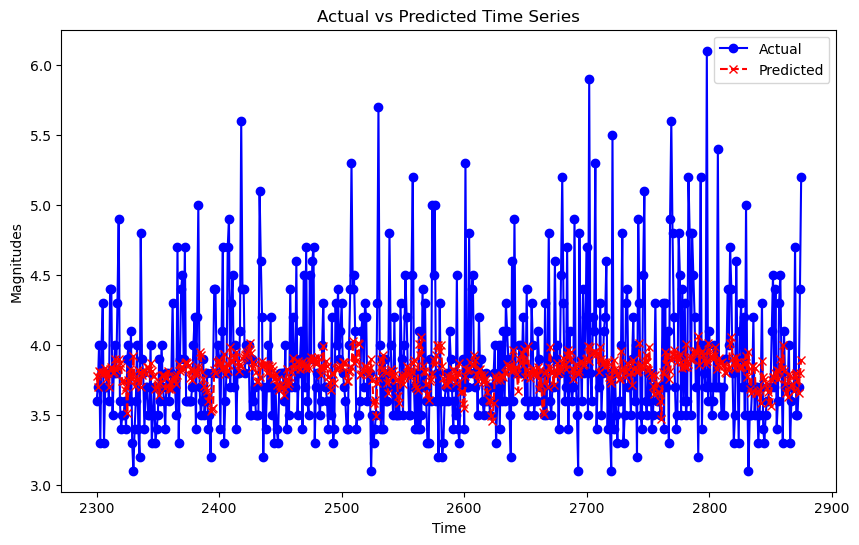

In [28]:
plot_time_series(y_test,y_pred)

# 2. Random Forest classifier

In [30]:
rf_model = RandomForestRegressor(random_state=42)
X_train_scaled, X_test_scaled, y_train, y_test, tscv=prepare_time_series_data_with_feature_selection(rf_model,df)

In [88]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=tscv, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Mean R²:", scores.mean())
print("Standard Deviation:", scores.std())

# Fit the model on the training set
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model using regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Cross-Validation R² Scores: [ 0.34605041 -2.28524336 -2.79828667]
Mean R²: -1.5791598728318677
Standard Deviation: 1.3773475328178706
Mean Absolute Error (MAE): 0.23890451388888895
Mean Squared Error (MSE): 0.11265365104166664
R² Score: 0.5181839370056817


# Hyper Parameter Tuning

In [90]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="r2").mean()
    return score

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the Best Model
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_rf.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

[I 2025-03-14 13:28:18,315] A new study created in memory with name: no-name-a5d4b720-59cc-411e-b667-3177c324d301
[I 2025-03-14 13:28:20,174] Trial 0 finished with value: 0.04327125887935057 and parameters: {'n_estimators': 80, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.04327125887935057.
[I 2025-03-14 13:28:36,036] Trial 1 finished with value: -0.5150640791681033 and parameters: {'n_estimators': 719, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.04327125887935057.
[I 2025-03-14 13:28:55,685] Trial 2 finished with value: -0.5443577963436419 and parameters: {'n_estimators': 837, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.04327125887935057.
[I 2025-03-14 13:29:14,561] Trial 3 finished with value: 0.042877359791728464 and parameters: {'n_estimators': 968, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 wit

Best Hyperparameters: {'n_estimators': 406, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}
Mean Absolute Error (MAE): 0.24516511809419367
Mean Squared Error (MSE): 0.12192788864461018
R² Score: 0.47851831935542555


In [32]:
best_params={'n_estimators': 406, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_rf.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.24516511809419367
Mean Squared Error (MSE): 0.12192788864461018
R² Score: 0.47851831935542555


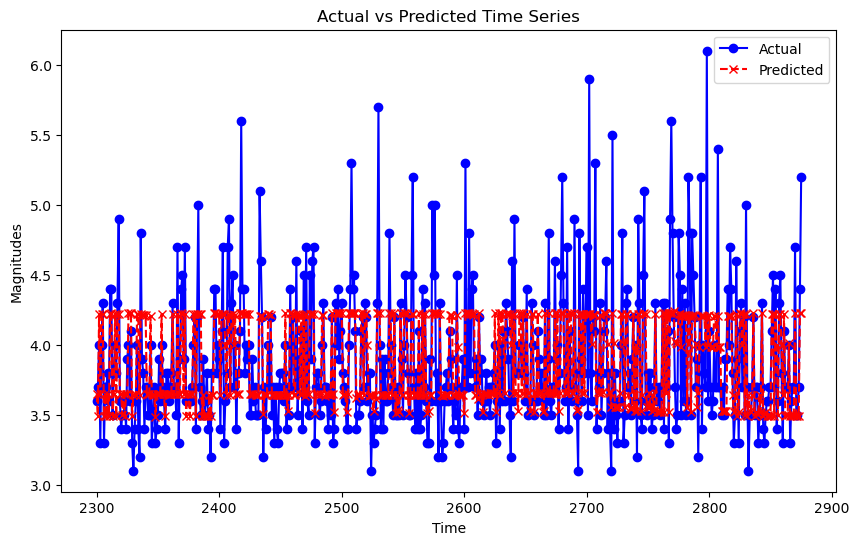

In [34]:
plot_time_series(y_test,y_pred)

# 3. SVM

In [100]:
from sklearn.svm import LinearSVR
model_svm = LinearSVR(random_state=42)
X_train_scaled, X_test_scaled, y_train, y_test, tscv=prepare_time_series_data_with_feature_selection(model_svm,df)

/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to 

In [102]:
import optuna
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Define Objective Function for Optuna
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 100)
    epsilon = trial.suggest_loguniform("epsilon", 1e-4, 1.0)
    
    model = LinearSVR(C=C, epsilon=epsilon, random_state=42, max_iter=10000)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="r2").mean()
    return score

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best Hyperparameters and Best Cross-Validation Score
best_params = study.best_params
best_cv_score = study.best_value
print("Best Hyperparameters:", best_params)
print(f"Best Cross-Validation R² Score: {best_cv_score:.4f}")

# Train the Best Model
best_svm = LinearSVR(**best_params, random_state=42, max_iter=10000)
best_svm.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


[I 2025-03-14 13:37:09,471] A new study created in memory with name: no-name-2a724960-c597-421c-9072-c5a6d57433d0
/tmp/ipykernel_42503/2127819612.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 100)
/tmp/ipykernel_42503/2127819612.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-4, 1.0)
/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/bishnu/anaconda3/lib/python3.12/site-packa

Best Hyperparameters: {'C': 14.195271986501675, 'epsilon': 0.4924803886151577}
Best Cross-Validation R² Score: 0.0922
Mean Absolute Error (MAE): 0.3518733082752063
Mean Squared Error (MSE): 0.22134526633176904
R² Score: 0.05331337422027671


/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [104]:
best_params= {'C': 14.195271986501675, 'epsilon': 0.4924803886151577}
#Best Cross-Validation R² Score: -2.2765,R² Score: 0.013383293358250059
best_svm = LinearSVR(**best_params, random_state=42, max_iter=10000)
best_svm.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Mean Absolute Error (MAE): 0.3518733082752063
Mean Squared Error (MSE): 0.22134526633176904
R² Score: 0.05331337422027671


/home/bishnu/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


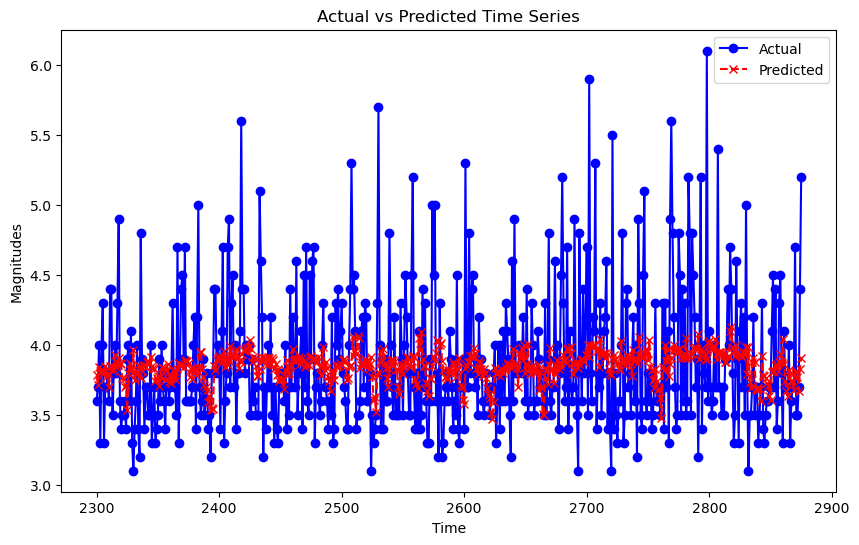

In [106]:
plot_time_series(y_test,y_pred)

# 4. Catboost Regressor

In [36]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(verbose=0,random_state=42)
X_train_scaled, X_test_scaled, y_train, y_test, tscv=prepare_time_series_data_with_feature_selection(model_cat,df)

In [112]:
import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define Objective Function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_loguniform("random_strength", 1e-3, 10),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 1e-3, 1.0),
        "border_count": trial.suggest_int("border_count", 10, 255),
        "verbose": 0,
        "random_seed": 42,
    }
    
    model = CatBoostRegressor(**params)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="r2").mean()
    return score

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best Hyperparameters and Best Cross-Validation Score
best_params = study.best_params
best_cv_score = study.best_value
print("Best Hyperparameters:", best_params)
print(f"Best Cross-Validation R² Score: {best_cv_score:.4f}")

# Train the Best Model
best_catboost = CatBoostRegressor(**best_params, random_seed=42)
best_catboost.fit(X_train_scaled, y_train, verbose=0)

# Predict on Test Set
y_pred = best_catboost.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

[I 2025-03-14 13:44:08,498] A new study created in memory with name: no-name-acb39feb-7b98-42d9-a493-ba5ee68fbcbc
/tmp/ipykernel_42503/800646932.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
/tmp/ipykernel_42503/800646932.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10),
/tmp/ipykernel_42503/800646932.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "random_strength"

Best Hyperparameters: {'iterations': 534, 'depth': 3, 'learning_rate': 0.00504672610695309, 'l2_leaf_reg': 1.5823004189153123, 'random_strength': 0.26078578203282377, 'bagging_temperature': 0.012675452868610422, 'border_count': 116}
Best Cross-Validation R² Score: 0.1754
Mean Absolute Error (MAE): 0.24635129485450305
Mean Squared Error (MSE): 0.12025485656981763
R² Score: 0.48567382403801784


In [37]:
best_params={'iterations': 534, 'depth': 3, 'learning_rate': 0.00504672610695309, 'l2_leaf_reg': 1.5823004189153123,
             'random_strength': 0.26078578203282377, 'bagging_temperature': 0.012675452868610422, 'border_count': 116}
#Best Cross-Validation R² Score: 0.3174
best_catboost = CatBoostRegressor(**best_params, random_seed=42)
best_catboost.fit(X_train_scaled, y_train, verbose=0)

# Predict on Test Set
y_pred = best_catboost.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.2454782818238728
Mean Squared Error (MSE): 0.12321570942724362
R² Score: 0.4730103510508634


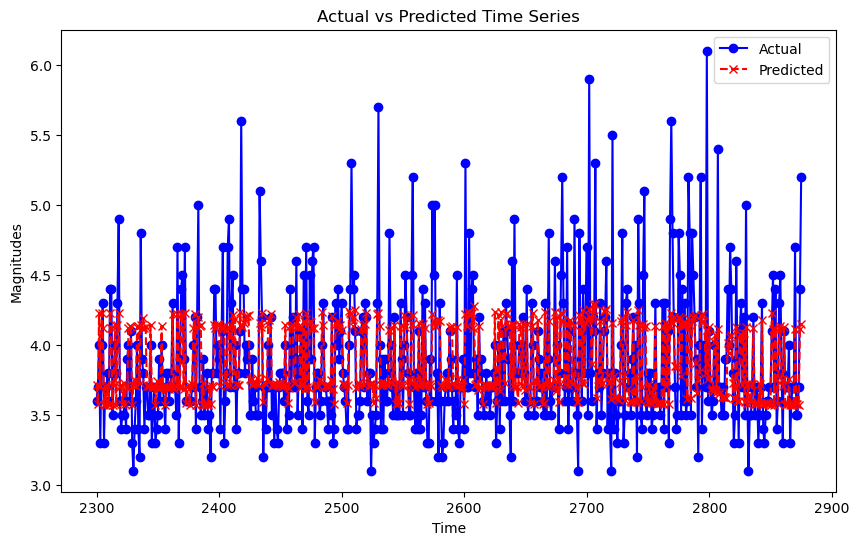

In [38]:
plot_time_series(y_test,y_pred)

# 5. XGboost

In [39]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(random_state=42)
X_train_scaled, X_test_scaled, y_train, y_test, tscv=prepare_time_series_data_with_feature_selection(model_xgb,df)

In [120]:
import optuna
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit



# Define Objective Function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-3, 10),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10),
        "verbose": 0
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="r2").mean()
    return score

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best Hyperparameters and Best Cross-Validation Score
best_params = study.best_params
best_cv_score = study.best_value
print("Best Hyperparameters:", best_params)
print(f"Best Cross-Validation R² Score: {best_cv_score:.4f}")

# Train the Best Model
best_xgboost = xgb.XGBRegressor(**best_params, random_state=42)
best_xgboost.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_xgboost.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


[I 2025-03-14 13:49:50,937] A new study created in memory with name: no-name-30798833-d784-4e2e-9168-5d6421addff5
/tmp/ipykernel_42503/4024869769.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
/tmp/ipykernel_42503/4024869769.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/tmp/ipykernel_42503/4024869769.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_b

Best Hyperparameters: {'n_estimators': 935, 'max_depth': 7, 'learning_rate': 0.00807954988627567, 'subsample': 0.7919577777249975, 'colsample_bytree': 0.7635284421655973, 'gamma': 0.18221567314000864, 'alpha': 3.8841330396675384, 'lambda': 0.19560300372882894}
Best Cross-Validation R² Score: 0.2558
Mean Absolute Error (MAE): 0.24431593914826713
Mean Squared Error (MSE): 0.12004968271732697
R² Score: 0.486551346043939


In [40]:
best_params={'n_estimators': 935, 'max_depth': 7, 'learning_rate': 0.00807954988627567,
             'subsample': 0.7919577777249975, 'colsample_bytree': 0.7635284421655973, 
             'gamma': 0.18221567314000864, 'alpha': 3.8841330396675384, 'lambda': 0.19560300372882894}
#Best Cross-Validation R² Score: 0.3326
best_xgboost = xgb.XGBRegressor(**best_params, random_state=42)
best_xgboost.fit(X_train_scaled, y_train)

# Predict on Test Set
y_pred = best_xgboost.predict(X_test_scaled)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.2395013422601753
Mean Squared Error (MSE): 0.11427783860925882
R² Score: 0.5112373387184044


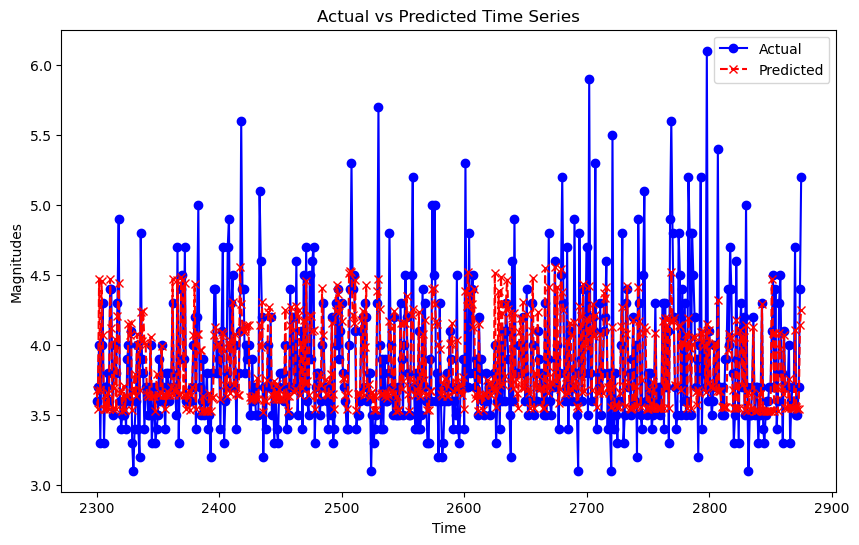

In [41]:
plot_time_series(y_test,y_pred)

In [50]:
# Run this in your Jupyter Notebook after training
import joblib

# Example for Random Forest (do this for each model)
joblib.dump(best_rf, 'models/rf_model.joblib')
joblib.dump(best_xgboost, 'models/xgb_model.joblib')
joblib.dump(best_catboost, 'models/cat_model.joblib')
joblib.dump(ridge, 'models/ridge_model.joblib')

# Also save the data splits and scaler
# We need X_test and y_test to evaluate predictions
X_train_scaled, X_test_scaled, y_train, y_test, tscv = prepare_time_series_data_with_feature_selection(model_xgb, df)
joblib.dump(y_test, 'models/y_test.joblib')

['models/y_test.joblib']

# Summary of model

# 1. Linear Regression:
    Best Cross-Validation Score: 0.10572987891348407.
    Best Hyperparameters: {'alpha': 160.37582726082957}
    Mean Absolute Error (MAE): 0.3497364604333073
    Mean Squared Error (MSE): 0.22652662880461882
    R² Score: 0.031152852616838977
# 2.Random Forest

    Best Cross-Validation Score: 0.2425557364625586.
    Best Hyperparameters: {'n_estimators': 406, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}
    Mean Absolute Error (MAE): 0.24516511809419367
    Mean Squared Error (MSE): 0.12192788864461018
    R² Score: 0.47851831935542555

# 3. SVC Linear
    Best Hyperparameters: {'C': 14.195271986501675, 'epsilon': 0.4924803886151577}
    Best Cross-Validation R² Score: 0.0922
    Mean Absolute Error (MAE): 0.3518733082752063
    Mean Squared Error (MSE): 0.22134526633176904
    R² Score: 0.05331337422027671

   
# 4. Catboost
    Best Hyperparameters: {'iterations': 534, 'depth': 3, 'learning_rate': 0.00504672610695309, 'l2_leaf_reg': 1.5823004189153123, 'random_strength': 0.26078578203282377, 'bagging_temperature': 0.012675452868610422, 'border_count': 116}
    Best Cross-Validation R² Score: 0.1754
    Mean Absolute Error (MAE): 0.24635129485450305
    Mean Squared Error (MSE): 0.12025485656981763
    R² Score: 0.48567382403801784
# 5. XGBoost
    Best Hyperparameters: {'n_estimators': 935, 'max_depth': 7, 'learning_rate': 0.00807954988627567, 'subsample': 0.7919577777249975, 'colsample_bytree': 0.7635284421655973, 'gamma': 0.18221567314000864, 'alpha': 3.8841330396675384, 'lambda': 0.19560300372882894}
    Best Cross-Validation R² Score: 0.2558
    Mean Absolute Error (MAE): 0.24431593914826713
    Mean Squared Error (MSE): 0.12004968271732697
    R² Score: 0.486551346043939